In [1]:
import random
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_words(file_path):
    def clean(word):
        return ''.join(filter(str.isalpha, word)).lower()
    with open(file_path, 'r') as file:
        words = [ clean(word) for word in file.read().splitlines() ]
        file.close()
    return words        

def read_data_from_dir(data_dir):
    words = []
    for file_path in os.listdir(data_dir):
        words.extend(read_words(data_dir + "/" + file_path))
    return words

In [3]:
### initializing dataset
data_path = '../data'
S = read_data_from_dir(data_path)

In [4]:
### set vocabulary mappings
chars = sorted(list(set(''.join(S))))
stoi = { s: i + 1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = { i: s for s, i in stoi.items() }
len(itos), len(stoi)

(48, 48)

In [5]:
random.seed(42069)
random.shuffle(S)
len(S)

40646

In [6]:
# These are hyper parameters I extracted from the lecture part
nneurons = 100 # number of neurons in hidden layer
vocab_size = len(stoi) # this is vocabulary size
block_size = 3 # this is how much will there be in each context
emb_size = 10 # this is how we will embed contexts
batch_size = 128 # for minibatch

In [7]:
### build dataset
def build_dataset(words):
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = int(0.8 * len(S))
n2 = int(0.9 * len(S))
X_train, y_train = build_dataset(S[:n1])
X_dev, y_dev = build_dataset(S[n1:n2])
X_test, y_test = build_dataset(S[n2:])

print(f'---- training set ----')
print(f'input shape: {X_train.shape}')
print(f'label shape: {y_train.shape}')
print(f'total samples: {X_train.shape[0]}')
print(f'---- validation set ----')
print(f'input shape: {X_dev.shape}')
print(f'label shape: {y_dev.shape}')
print(f'total samples: {X_dev.shape[0]}')
print(f'---- testing set ----')
print(f'input shape: {X_test.shape}')
print(f'label shape: {y_test.shape}')
print(f'total samples: {X_test.shape[0]}')

---- training set ----
input shape: torch.Size([231426, 3])
label shape: torch.Size([231426])
total samples: 231426
---- validation set ----
input shape: torch.Size([29091, 3])
label shape: torch.Size([29091])
total samples: 29091
---- testing set ----
input shape: torch.Size([28987, 3])
label shape: torch.Size([28987])
total samples: 28987


In [9]:
### neural network layers
g = torch.Generator().manual_seed(42069)
# this is lookup table
C = torch.randn((vocab_size, emb_size), generator=g)
W1 = torch.randn((block_size * emb_size, nneurons), generator=g) * 5 / 3 * (block_size * emb_size)**0.5
b1 = torch.randn(nneurons, generator=g)
# this is output layer
W2 = torch.randn((nneurons, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
params = [C, W1, b1, W2, b2]
for p in params:
    p.requires_grad = True

nparams = sum(p.nelement() for p in params)
print(f'---- neural network ----')
print(f'number of parameters: {nparams}')

---- neural network ----
number of parameters: 8428


In [10]:
### for tracking stats and tweaking learning rate
lre = torch.linspace(-3, 0, 10_000) # the last 10_000 should match number of epochs
lrs = 10 ** lre
lri = []
lossi = []
stepi = []

In [11]:
### training phase
for i in range(10_000):
    # minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ))
    
    # forward pass
    emb = C[X_train[ix]] # (batch_size, block_size, emb_size)
    h = torch.tanh(emb.view(-1, block_size * emb_size) @ W1 + b1) # (batch_size, nneurons)
    logits = h @ W2 + b2 # (batch_size, vocab_size)
    loss = F.cross_entropy(logits, y_train[ix])

    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # update parameters
    # lr = lrs[i]
    # stats have shown that learning rate at 0.5
    lr = 10 ** (-0.5)
    for p in params:
        p.data += -0.1 * p.grad

    # tracking stats
    # lri.append(lre[i])
    # stepi.append(i)
    # lossi.append(loss.log10().item())
print(loss.item())

2.6712486743927


In [16]:
# training loss
emb = C[X_train]
h = torch.tanh(emb.view(-1, block_size * emb_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
loss.item()

2.552379846572876

In [17]:
# validation loss
emb = C[X_dev]
h = torch.tanh(emb.view(-1, block_size * emb_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_dev)
loss.item()

2.550004005432129

In [18]:
# testing loss
emb = C[X_test]
h = torch.tanh(emb.view(-1, block_size * emb_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_test)
loss.item()

2.573753595352173

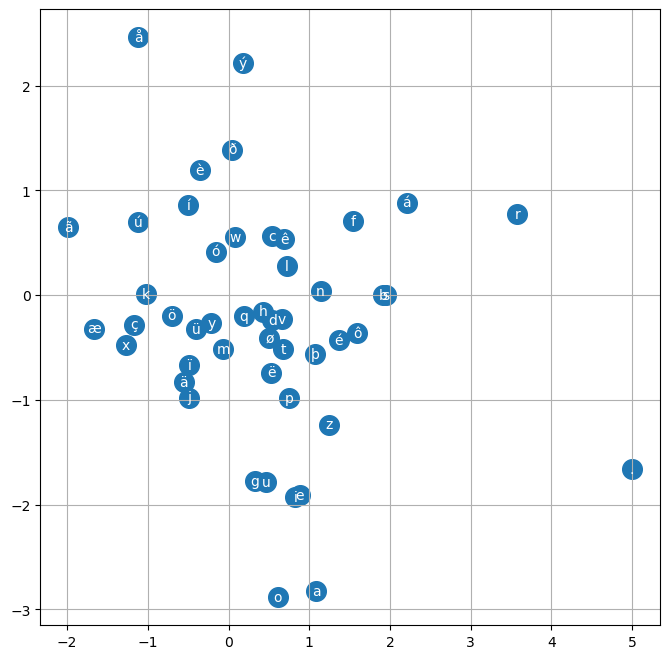

In [19]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid()

In [20]:
### sample from the model
for _ in range(20):
    word = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        word.append(ix)
        if ix == 0:
            break
    print('generated word:', ''.join(itos[i] for i in word))

generated word: agdura.
generated word: juv.
generated word: fili.
generated word: huan.
generated word: froidoliandrimolina.
generated word: jlenczd.
generated word: antera.
generated word: labiur.
generated word: louh.
generated word: kar.
generated word: nustarkinitenhadi.
generated word: enelek.
generated word: gante.
generated word: würislaosite.
generated word: dhadoyhrarurniimaouup.
generated word: faane.
generated word: kanlægssteehabidt.
generated word: zallarritheldionilahen.
generated word: olaaz.
generated word: ezimristu.
